In [1]:
# run on pth-gpu on HP Omen
# -*- coding: utf-8 -*-
import pickle as pkl
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
from input_data import preprocess_data,load_sz_data,load_los_data

from visualization import plot_result,plot_error
from sklearn.metrics import mean_squared_error,mean_absolute_error
#import matplotlib.pyplot as plt
import time

time_start = time.time()
###### Settings ######
data_name = 'sz' #'los'

###### load data ######
if data_name == 'sz':
    data, adj = load_sz_data('sz')
if data_name == 'los':
    data, adj = load_los_data('los')

data = data.drop(data.index[960:])

time_len = data.shape[0]
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32)

#### normalization
max_value = np.max(data1)
data1 = data1/max_value

In [2]:
print(time_len, num_nodes)
print(data.shape, data1.shape)

960 156
(960, 156) (960, 156)


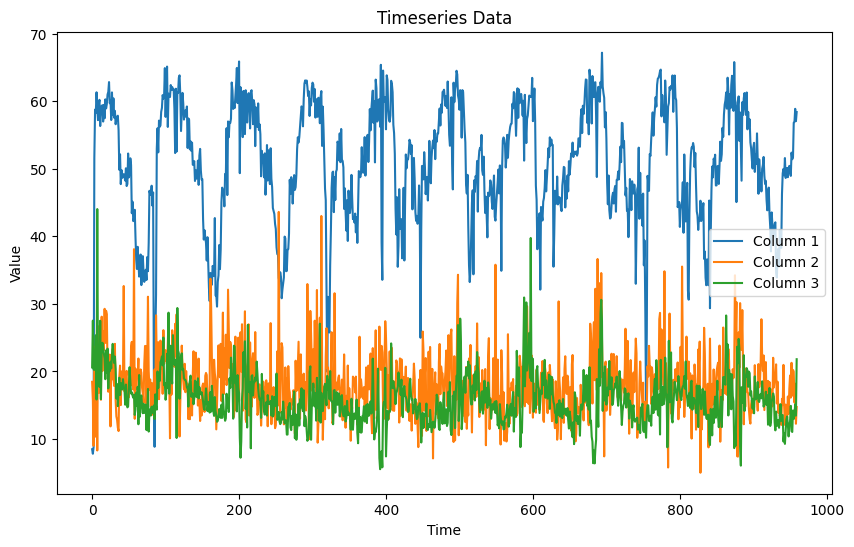

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
# X = data[:,0]

# Plot all the columns of X in a single plot
plt.figure(figsize=(10, 6))  # Set the figure size

for i in range(3):  # Loop through each column of X
    plt.plot(data.iloc[:, i], label=f'Column {i+1}')  # Plot the column data with a label

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.title('Timeseries Data')  # Set the title of the plot
plt.legend()  # Show the legend

plt.show()  # Show the plot


In [4]:
X = data.values
X.shape

(960, 156)

In [5]:
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

d:\ProgramData\Anaconda3\envs\pth-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# !pip install dagma

In [7]:
%%time
model = DagmaLinear(loss_type='l2') # create a linear model with least squares loss
W_est = model.fit(X, lambda1=0.02) # fit the model with L1 reg. (coeff. 0.02)
print(W_est.shape)


100%|██████████| 180000/180000.0 [03:50<00:00, 782.54it/s]  

(156, 156)
CPU times: total: 12min 23s
Wall time: 3min 50s


In [8]:
W_true = adj
W_true_normalized = (W_true - np.min(W_true)) / (np.max(W_true) - np.min(W_true)) * 255
W_est_normalized = (W_est - np.min(W_est)) / (np.max(W_est) - np.min(W_est)) * 255

# Convert to uint8
W_true_img = W_true_normalized.astype(np.uint8)
W_est_img = W_est_normalized.astype(np.uint8)

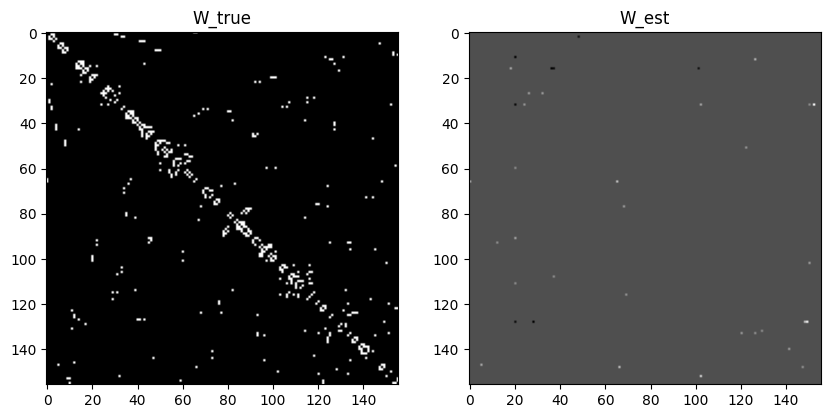

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(adj, cmap='gray')
axs[0].set_title('W_true')

axs[1].imshow(W_est_img, cmap='gray')
axs[1].set_title('W_est')

plt.show()


In [12]:
W_true[1], W_est[1]

(matrix([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 